In [55]:
import numpy as np
import gcsfs
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import intake
import xesmf as xe
%matplotlib inline
import cartopy
from cartopy import util
import cartopy.crs as ccrs
import zarr
import dask.array as da  
from dask.diagnostics import ProgressBar
from tqdm.autonotebook import tqdm
import nc_time_axis
import time

import cmip6_preprocessing
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [14]:
#cat_url = "/space/hall4/sitestore/eccc/crd/CMIP6/final/canesm_final.json"
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [15]:
# Fix some inconsistencies across datasets like dimension names, bounds, extra variables, etc.
from cmip6_preprocessing.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon, rename_cmip6

def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    return ds

In [57]:
query = dict(table_id=['Amon'], 
             variable_id=['tas'], source_id='CanESM5', 
             experiment_id=['historical', 'ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585'])
cat = col.search(**query)
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                    storage_options={'token': 'anon'}, 
                                    preprocess=wrapper,)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 6 group(s)
[########################################] | 100% Completed | 58.4s


In [58]:
query = dict(table_id=['fx'], 
             variable_id=['areacella'], source_id='CanESM5', 
             experiment_id=['historical'], member_id='r1i1p1f1')
cat = col.search(**query)
dset_dict_areacella = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                    storage_options={'token': 'anon'}, 
                                    preprocess=wrapper,)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 1 group(s)
[########################################] | 100% Completed |  0.3s


In [59]:
areacella = dset_dict_areacella['CMIP.CCCma.CanESM5.historical.fx.gn'].areacella.squeeze()

In [60]:
gmst_dict = {}
glob_area = areacella.sum(dim=['lon', 'lat'])

for key, data in dset_dict.items():
    exp = key.split('.')[3]
    gmst_dict[exp] = ((dset_dict[key] * areacella).sum(dim=['lon', 'lat'])/glob_area.values).compute()

In [61]:
ref = gmst_dict['historical']['tas'].sel(time=slice('1850', '1900')).mean(dim='time').mean(dim='member_id')

In [62]:
ref = gmst_dict['historical']['tas'].sel(time=slice('1850', '1900')).mean(dim='time').mean(dim='member_id')

In [63]:
gmst_anoms = {}
for key, data in gmst_dict.items():
    gmst_anoms[key] = (data.sel(time=slice('1850','2100')) - ref.values).groupby('time.year').mean(dim='time').compute()

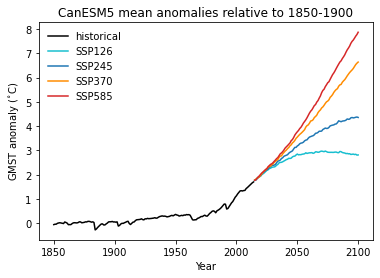

In [64]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(gmst_anoms['historical'].year, gmst_anoms['historical']['tas'].mean(dim='member_id'), color='k', label='historical')
ax.plot(gmst_anoms['ssp126'].year, gmst_anoms['ssp126']['tas'].mean(dim='member_id'), color='tab:cyan', label='SSP126')
ax.plot(gmst_anoms['ssp245'].year, gmst_anoms['ssp245']['tas'].mean(dim='member_id'), color='tab:blue', label='SSP245')
ax.plot(gmst_anoms['ssp370'].year, gmst_anoms['ssp370']['tas'].mean(dim='member_id'), color='darkorange', label='SSP370')
ax.plot(gmst_anoms['ssp585'].year, gmst_anoms['ssp585']['tas'].mean(dim='member_id'), color='tab:red', label='SSP585')
ax.legend(frameon=False)
ax.set_ylabel('GMST anomaly ($^{\circ}$C)')
ax.set_xlabel('Year')
ax.set_title('CanESM5 mean anomalies relative to 1850-1900')
fig.savefig('CanESM5_GMST_anomalies.png', bbox_inches='tight', dpi=300)

In [65]:
obs = xr.open_dataset('fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc')

In [66]:
obs_anom = (obs - obs.sel(time=slice('1850','1900')).mean(dim='time')).groupby('time.year').mean(dim='time')

In [67]:
upper_bounds = {}
lower_bounds = {}
for key, data in gmst_anoms.items():
    upper_bounds[key] = (data['tas'].mean(dim='member_id') + 
                         data['tas'].std(dim='member_id')*2.0)#/np.sqrt(len(data['tas'].member_id)))
    lower_bounds[key] = (data['tas'].mean(dim='member_id') -
                         data['tas'].std(dim='member_id')*2.0)#/np.sqrt(len(data['tas'].member_id))) 

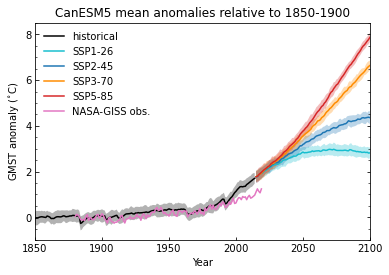

In [68]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

colors = ['k', 'tab:cyan', 'tab:blue', 'darkorange', 'tab:red']
label = ['historical', 'SSP1-26', 'SSP2-45', 'SSP3-70', 'SSP5-85']
for i, key in enumerate(['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax.fill_between(gmst_anoms[key].year, upper_bounds[key], lower_bounds[key], 
                    facecolor=colors[i], alpha=0.3)

    ax.plot(gmst_anoms[key].year, gmst_anoms[key]['tas'].mean(dim='member_id'), 
            color=colors[i], label=label[i])
    
ax.plot(obs_anom.year, obs_anom.tempanomaly.squeeze(), 'tab:pink', label='NASA-GISS obs.')
ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('GMST anomaly ($^{\circ}$C)')
ax.set_xlabel('Year')
ax.set_xlim([1850, 2100])
ax.set_title('CanESM5 mean anomalies relative to 1850-1900')
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', left=True, right=True, which='both', direction='in')
fig.savefig('CanESM5_GMST_anomalies_plus-obs.png', bbox_inches='tight', dpi=300)

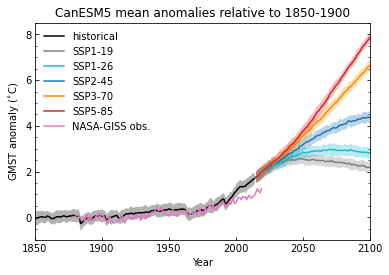

In [69]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

colors = ['k', 'tab:grey','tab:cyan', 'tab:blue', 'darkorange', 'tab:red']
label = ['historical', 'SSP1-19', 'SSP1-26', 'SSP2-45', 'SSP3-70', 'SSP5-85']
for i, key in enumerate(['historical', 'ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax.fill_between(gmst_anoms[key].year, upper_bounds[key], lower_bounds[key], 
                    facecolor=colors[i], alpha=0.3)

    ax.plot(gmst_anoms[key].year, gmst_anoms[key]['tas'].mean(dim='member_id'), 
            color=colors[i], label=label[i])
    
ax.plot(obs_anom.year, obs_anom.tempanomaly.squeeze(), 'tab:pink', label='NASA-GISS obs.')
ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('GMST anomaly ($^{\circ}$C)')
ax.set_xlabel('Year')
ax.set_xlim([1850, 2100])
ax.set_title('CanESM5 mean anomalies relative to 1850-1900')
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', left=True, right=True, which='both', direction='in')
fig.savefig('CanESM5_GMST_anomalies_plus-obs.png', bbox_inches='tight', dpi=300)